# Liver Model Construction: Notebook

In [1]:
import os
import re
import warnings
# from cobra.io import *
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
# from cobra.io.json import *
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [2]:
import sys
# from minspan import minspan,nnz
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [3]:
type(dict)

type

In [4]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")
# extra_dir=os.path.abspath("..")
# minspan_dir

### Getting reactions and metabolite data from RECON 3D

In [5]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"gly_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')


### Loading cobra model

In [6]:
# Initiate empty model
trial= cobra.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-02


In [7]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

In [8]:
import json

In [9]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"gly_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [10]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    print(reaction)

HEX1
PGI
FBP
PFK
FBA
TPI
GAPD
PGK
PGM
ENO
PYK
LDH_L
ATPM


In [11]:
nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
rxn = cobra.Reaction('NADHM')
trial.add_reaction(rxn)
rxn.add_metabolites(nadhm)

In [12]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {'charge': -1.0}
PGI {}
FBP {'charge': 2.0}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PYK {'charge': 1.0}
LDH_L {'charge': -1.0}
ATPM {'charge': 1.0}
NADHM {'charge': 1}


In [13]:
trial.metabolites.h_c.charge= 1
# trial.metabolites.h_e.charge= 1
trial.metabolites.pi_c.charge= -2

In [14]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {}
PGI {}
FBP {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PYK {}
LDH_L {}
ATPM {}
NADHM {'charge': 2}


In [15]:
for met in ['glc__D_c', 'h2o_c', 'h_c', 'pi_c','lac__L_c', "pyr_c"]:
    rxn = cobra.Reaction('EX_%s' % met)
    trial.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # by convention negative exchange flux = uptake
    elif met == 'pyr_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000

In [16]:
for reaction in trial.reactions:
    print(reaction)

HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c
PGI: g6p_c <=> f6p_c
FBP: fdp_c + h2o_c --> f6p_c + pi_c
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c
FBA: fdp_c <=> dhap_c + g3p_c
TPI: dhap_c <=> g3p_c
GAPD: g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c
PGM: 2pg_c <=> 3pg_c
ENO: 2pg_c <=> h2o_c + pep_c
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c
LDH_L: lac__L_c + nad_c <=> h_c + nadh_c + pyr_c
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
NADHM: nadh_c --> h_c + nad_c
EX_glc__D_c: glc__D_c <=> 
EX_h2o_c: h2o_c <=> 
EX_h_c: h_c <=> 
EX_pi_c: pi_c <=> 
EX_lac__L_c: lac__L_c <=> 
EX_pyr_c: pyr_c --> 


In [17]:
trial.objective = 'ATPM'
flux_solution = trial.optimize()
flux_solution

,fluxes,reduced_costs
HEX1,1.0,0.0
PGI,1.0,0.0
FBP,0.0,-2.0
PFK,1.0,0.0
FBA,1.0,0.0
...,...,...
EX_h2o_c,0.0,-0.0
EX_h_c,2.0,0.0
EX_pi_c,0.0,0.0
EX_lac__L_c,2.0,0.0


In [18]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 1.0, 'PGI': 1.0, 'FBP': 0.0, 'PFK': 1.0, 'FBA': 1.0, 'TPI': 1.0, 'GAPD': 2.0, '…

In [19]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [20]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    # met_df=met_df.append(df_2)
    met_df = pd.concat([met_df, df_2])
met_df=met_df.set_index('id')

In [21]:
met_df

,name,charge,formula,compartment
id,,,,
adp_c,ADP C10H12N5O10P2,-3,C10H12N5O10P2,c
atp_c,ATP C10H12N5O13P3,-4,C10H12N5O13P3,c
g6p_c,D-Glucose 6-phosphate,-2,C6H11O9P,c
glc__D_c,D-Glucose,0,C6H12O6,c
h_c,H+,1,H,c
f6p_c,D-Fructose 6-phosphate,-2,C6H11O9P,c
fdp_c,"D-Fructose 1,6-bisphosphate",-4,C6H10O12P2,c
h2o_c,H2O H2O,0,H2O,c
pi_c,Phosphate,-2,HO4P,c


In [22]:
csv_met_cobra = os.path.join(data_dir,"gly_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [23]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    # rxn_df=rxn_df.append(df)
    rxn_df = pd.concat([rxn_df, df])

rxn_df=rxn_df.set_index('id')

In [24]:
rxn_df

,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,objective_coefficient
id,,,,,,
HEX1,Hexokinase (D-glucose:ATP),"{'adp_c': 1.0, 'atp_c': -1.0, 'g6p_c': 1.0, 'g...",0.0,1000.0,,NaN
PGI,Glucose-6-phosphate isomerase,"{'f6p_c': 1.0, 'g6p_c': -1.0}",-1000.0,1000.0,,NaN
FBP,Fructose-bisphosphatase,"{'f6p_c': 1.0, 'fdp_c': -1.0, 'h2o_c': -1.0, '...",0.0,1000.0,,NaN
PFK,Phosphofructokinase,"{'adp_c': 1.0, 'atp_c': -1.0, 'f6p_c': -1.0, '...",0.0,1000.0,,NaN
FBA,Fructose-bisphosphate aldolase,"{'dhap_c': 1.0, 'fdp_c': -1.0, 'g3p_c': 1.0}",-1000.0,1000.0,,NaN
TPI,Triose-phosphate isomerase,"{'dhap_c': -1.0, 'g3p_c': 1.0}",-1000.0,1000.0,,NaN
GAPD,Glyceraldehyde-3-phosphate dehydrogenase,"{'13dpg_c': 1.0, 'g3p_c': -1.0, 'h_c': 1.0, 'n...",-1000.0,1000.0,,NaN
PGK,Phosphoglycerate kinase,"{'13dpg_c': 1.0, '3pg_c': -1.0, 'adp_c': 1.0, ...",-1000.0,1000.0,,NaN
PGM,Phosphoglycerate mutase,"{'2pg_c': -1.0, '3pg_c': 1.0}",-1000.0,1000.0,,NaN


In [25]:
json_rxn_cobra = os.path.join(data_dir,"gly_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra
,orient="index")

## Making MASS model of glycolysis

In [26]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model

In [27]:
import json

In [28]:
met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

In [29]:
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [30]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
#     if reaction_obj.id != "DM_nadh" or reaction_obj.id != 'ATPM':
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [31]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)
# liver.reactions.PGM

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x01e58508afa0
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


##  Set Fluxes

In [32]:
fluxes_mass = flux_solution.to_frame()
fluxes_mass

,fluxes,reduced_costs
HEX1,1.0,0.0
PGI,1.0,0.0
FBP,0.0,-2.0
PFK,1.0,0.0
FBA,1.0,0.0
TPI,1.0,0.0
GAPD,2.0,0.0
PGK,-2.0,-0.0
PGM,-2.0,-0.0
ENO,2.0,0.0


In [33]:
no_flux =[]
for r in liver.reactions:
    if r.id in fluxes_mass.index:
        flux =  fluxes_mass.loc[r.id,"fluxes"]
        # reaction = liver.reactions.get_by_id
        r.steady_state_flux = flux
        print(r.id, r.steady_state_flux)
        
    else:
        no_flux.append(r.id)

no_flux

HEX1 1.0
PGI 1.0
FBP 0.0
PFK 1.0
FBA 1.0
TPI 1.0
GAPD 2.0
PGK -2.0
PGM -2.0
ENO 2.0
PYK 2.0
LDH_L -2.0
ATPM 2.0
NADHM 0.0
EX_glc__D_c -1.0
EX_h2o_c 0.0
EX_h_c 2.0
EX_pi_c 0.0
EX_lac__L_c 2.0
EX_pyr_c 0.0


[]

## Setting initial conditions

In [34]:
import csv
import openpyxl

In [35]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [36]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations2.xlsx")
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)

In [37]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)

In [38]:
print("Initial Conditions\n------------------")

for met in liver.metabolites:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    if met.id in conc_df.index:
        mid=met.id
        # print(mid)
        # metabolite = reaction.metabolites
        ic_value = conc_df.loc[mid,'Concentration (M)']
        # print(mid,ic_value)
        met.ic =  (ic_value)            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
pi_c: 0.0064
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
13dpg_c: 2.43e-07
nad_c: 0.00182530972
nadh_c: 4.63542e-06
3pg_c: 0.000520630485
2pg_c: 0.000110560855
pep_c: 0.00031
pyr_c: 0.00047999999999999996
lac__L_c: 0.00326183772


### Getting Standard and Physiological Gibbs energies of reactions

In [39]:
reaction_str= []

cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import exp as exp


In [40]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions

excluded_reactions=["ATPM", 
# "NADHM",
]

In [41]:
print("Boundary Reactions and Values\n-----------------------------")
for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

# Trying to set these as 1e6 becasue the inf might be messing with the solver
liver.reactions.ATPM.Keq=1e6
liver.reactions.NADHM.Keq=1e6

Boundary Reactions and Values
-----------------------------
EX_glc__D_c: glc__D_c <=> 
glc__D_b: 0.01048280703

EX_pi_c: pi_c <=> 
pi_b: 0.0064

EX_lac__L_c: lac__L_c <=> 
lac__L_b: 0.00326183772

EX_pyr_c: pyr_c <=> 
pyr_b: 0.00047999999999999996



In [42]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")    

HEX1
Keq = 4959.419292148073
PGI
Keq = 0.34798040939490554
FBP
Keq = 115004.76795942851
PFK
Keq = 1454.9063091036724
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PYK
Keq = 10333.2896179346
LDH_L
Keq = 0.00013815091719569572
NADHM
Keq = 225587875156.06818


In [43]:
liver.metabolites.h_c.charge= 1
# liver.metabolites.h_e.charge= 1
liver.metabolites.pi_c.charge= -2

In [44]:
metabolite_ids = [m.id for m in liver.metabolites]
misbalance= pd.DataFrame(
    liver.S.dot(np.array(list(liver.steady_state_fluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"])
misbalance.T

,adp_c,atp_c,g6p_c,glc__D_c,h_c,f6p_c,fdp_c,h2o_c,pi_c,dhap_c,g3p_c,13dpg_c,nad_c,nadh_c,3pg_c,2pg_c,pep_c,pyr_c,lac__L_c
$\textbf{Sv}_{\mathrm{stst}}$,4.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0


## Setting initial conditions

In [45]:
# import csv
# csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.csv")
# # opening the CSV file
# with open(csv_ic, mode ='r')as file:
   
#   # reading the CSV file
#     csvFile = csv.reader(file)

#       # displaying the contents of the CSV file
#     for name, value in csvFile:
#         met_id = liver.metabolites.get_by_id(name)
#         met_id.ic = float(value) #M
#         print(met_id, ":", met_id.ic)

## Set H2O/H Constants

In [46]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [47]:
for metabolite in [
#     'h_m',
"h_c", 
#     'h_e',
"h2o_c",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [48]:
for metabolite in liver.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
h2o_c: 1
pi_c: 0.0064
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
13dpg_c: 2.43e-07
nad_c: 0.00182530972
nadh_c: 4.63542e-06
3pg_c: 0.000520630485
2pg_c: 0.000110560855
pep_c: 0.00031
pyr_c: 0.00047999999999999996
lac__L_c: 0.00326183772


In [49]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",
#     "pi_e",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
#     excluded_reactions=["Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
#     'L_LACt2r','PYRt2'],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['FBP', 'NADHM']
['FBP', 'NADHM']
mass\util\util.py:159 UserWarning: Unrecognized kwargs: ['Keq_percent_deviation']
mass\thermo\conc_solution.py:98 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
mass\thermo\conc_solution.py:99 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,variables,reduced_costs
adp_c,0.001995,0.0
atp_c,0.004727,0.0
g6p_c,0.000269,0.0
glc__D_c,0.010483,0.0
f6p_c,0.000066,0.0
...,...,...
Keq_PGM,0.137497,0.0
Keq_ENO,4.850113,0.0
Keq_PYK,10333.289618,0.0
Keq_LDH_L,0.000101,0.0


In [50]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [51]:
#Compare Results
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info = load_data(
    filepath=csv_ic,
    sheet_name="Concentrations")

mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'_3pg_c', '_2pg_c'}, only in one set of given values


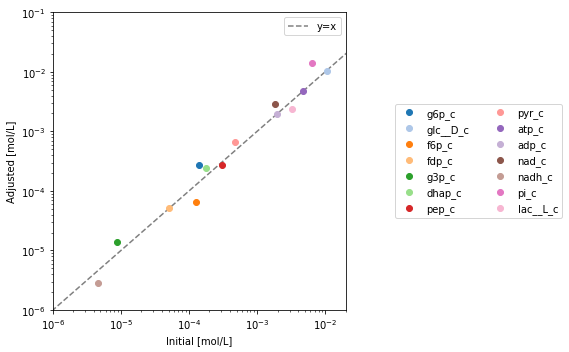

In [52]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=ic_info["Concentrations in M"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in ic_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True);

In [53]:
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True)

Name,Core_Model
Memory address,0x01e58506eb50
Stoichiometric Matrix,19x20
Matrix Rank,17
Number of metabolites,19
Initial conditions defined,19/19
Number of reactions,20
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


In [54]:
seed = int(1)
n_models = 15

In [55]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(liver.fixed),
    # fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    )
for variable in conc_solver.variables:
    try:
        met = liver.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models,  processes=4, seed=seed)
conc_samples.head()


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmphjc5fi0g.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpr0r_3afu.lp
Reading time = 0.00 seconds
: 12 rows, 29 columns, 51 nonzeros


,adp_c,atp_c,g6p_c,glc__D_c,f6p_c,fdp_c,pi_c,dhap_c,g3p_c,13dpg_c,nad_c,nadh_c,3pg_c,2pg_c,pep_c,pyr_c,lac__L_c
0,0.001484,0.018322,0.002407,0.012817,0.000396,0.000046,0.010269,0.001790,0.000110,2.482192e-07,0.004670,0.000012,0.000087,0.000118,0.000041,0.000413,0.000308
1,0.000355,0.008343,0.001950,0.040760,0.000010,0.000119,0.028048,0.000435,0.000015,5.522913e-07,0.022479,0.000008,0.000158,0.000400,0.000164,0.001288,0.000868
2,0.010154,0.022036,0.000170,0.022727,0.000008,0.000052,0.032541,0.000456,0.000029,5.002616e-07,0.012141,0.000008,0.003161,0.001485,0.000717,0.003730,0.001842
3,0.002294,0.025942,0.000171,0.016920,0.000009,0.000266,0.010349,0.000826,0.000057,2.304069e-07,0.003855,0.000002,0.000225,0.000070,0.000097,0.000634,0.000387
4,0.004191,0.002637,0.001064,0.026194,0.000009,0.000061,0.064537,0.000642,0.000022,3.127800e-08,0.001855,0.000001,0.000522,0.000306,0.000071,0.000562,0.001121


In [124]:
percs_df = pd.DataFrame()

percs = liver.calculate_PERCs(
    fluxes={
        r: v for r, v in liver.steady_state_fluxes.items()
        if not r.boundary},
    update_reactions=True)

percs_df = pd.DataFrame.from_dict(percs, orient='index', columns = ["OG"])
percs_df

,OG
kf_HEX1,2.018015e+04
kf_PGI,5.880895e+03
kf_FBP,1.000000e+05
kf_PFK,3.197816e+06
kf_FBA,1.943647e+04
kf_TPI,6.486470e+03
kf_GAPD,5.434709e+09
kf_PGK,2.530817e+09
kf_PGM,2.803163e+03
kf_ENO,2.038713e+04


In [125]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = liver.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        # try:
            # Update PERCs
        percs = new_model.calculate_PERCs(
            fluxes={
                r: v for r, v in new_model.steady_state_fluxes.items()
                if not r.boundary},
            update_reactions=True)
    df_p = pd.DataFrame.from_dict(percs, orient='index')
    df_p.columns = [("No."+ str(idx))]
    percs_df = pd.merge(percs_df, df_p, how='inner', left_index=True, right_index=True)
        # except:
        #     print("Negative PERCs for {0}".format(new_model.id))

        #     df_p = pd.DataFrame.from_dict(percs, orient='index')
        #     df_p.columns = [("No."+ str(idx))]
        #     percs_df = pd.merge(percs_df, df_p, how='inner', left_index=True, right_index=True)
        #     percs_df = pd.join([percs_df, df_p])
            
            # continue



        
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpc2aqnlpd.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmprjigi6ye.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpth5snq59.lp
Reading time = 0.00 seconds
: 12 rows, 29 columns, 51 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpbft6amgg.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpj8dypakl.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpfop68d80.lp
Reading time = 0.00 seconds
: 12 rows, 29 columns, 51 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpgsyf6t1t.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 non

### FOrming Percs Dataframe

In [170]:
percs_df

,OG,No.0,No.1,No.2,No.3,No.4,No.5,No.6,No.7,No.8,No.9,No.10,No.11,No.12,No.13,No.14,No.15
kf_HEX1,2.018015e+04,4.258354e+03,2.940531e+03,1.996763e+03,2.278241e+03,1.447698e+04,3.898891e+04,1.816423e+04,1.120087e+04,5.408917e+03,2.079435e+04,1.107742e+04,2.983098e+03,1.014327e+04,9.616852e+03,8.580710e+03,4.536525e+04
kf_PGI,5.880895e+03,5.511449e+02,5.168686e+02,6.340910e+03,6.306921e+03,9.512147e+02,6.557451e+02,4.315195e+02,3.030961e+03,1.080550e+03,9.089879e+02,1.560218e+04,5.046153e+03,3.048022e+03,4.145230e+03,1.208578e+04,1.462376e+04
kf_FBP,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
kf_PFK,3.197816e+06,1.377600e+05,1.210078e+07,5.624837e+06,4.528822e+06,4.402672e+07,1.857294e+07,1.232876e+06,7.257629e+05,4.595316e+05,8.889015e+05,4.773050e+06,4.465950e+06,1.252645e+06,3.963208e+06,9.884378e+06,3.171821e+07
kf_FBA,1.943647e+04,2.257384e+04,8.439185e+03,1.931098e+04,3.764272e+03,1.645918e+04,1.337174e+04,7.734308e+03,9.174712e+03,3.617749e+03,2.717625e+03,4.547950e+04,6.744143e+03,3.338812e+04,1.848849e+04,4.033850e+03,2.251593e+04
kf_TPI,6.486470e+03,9.195787e+02,2.936766e+03,3.740340e+03,2.157476e+03,1.994646e+03,2.386361e+03,3.112682e+03,1.517118e+03,4.577051e+03,1.865297e+03,1.424727e+03,7.891847e+03,2.867054e+03,8.184028e+02,5.807915e+02,1.872095e+03
kf_GAPD,5.434709e+09,6.101805e+08,3.258215e+08,2.241215e+08,1.021928e+09,7.666868e+08,1.355283e+09,3.250276e+09,1.458935e+09,1.184106e+09,9.654395e+08,1.285955e+10,1.160672e+10,6.439369e+08,3.830395e+08,4.327827e+07,1.768913e+09
kf_PGK,2.530817e+09,4.460508e+09,4.152088e+09,6.502157e+07,8.100133e+08,3.466810e+09,6.042706e+09,2.090652e+09,3.814805e+08,1.444397e+09,1.392524e+10,2.153272e+09,1.925818e+09,5.461305e+09,4.272434e+09,1.574623e+09,9.581188e+09
kf_PGM,2.803163e+03,2.582658e+03,7.266611e+02,2.617806e+02,7.086623e+03,1.176226e+03,2.268128e+02,8.105503e+02,4.389029e+02,4.032394e+02,1.995419e+03,3.594604e+03,2.729473e+03,5.030489e+03,3.241569e+02,1.123723e+03,2.540715e+03
kf_ENO,2.038713e+04,1.817571e+04,5.460263e+03,1.495655e+03,4.033576e+04,6.873084e+03,1.588397e+03,5.433856e+03,3.241089e+03,2.799281e+03,1.535439e+04,2.283969e+04,2.304732e+04,3.779054e+04,2.349906e+03,9.713657e+03,2.356747e+04


Log transforming it

In [171]:
data_log = np.log(percs_df)
data_log

,OG,No.0,No.1,No.2,No.3,No.4,No.5,No.6,No.7,No.8,No.9,No.10,No.11,No.12,No.13,No.14,No.15
kf_HEX1,9.912455,8.356638,7.986346,7.599283,7.731159,9.580315,10.571033,9.807210,9.323747,8.595804,9.942436,9.312664,8.000718,9.224566,9.171272,9.057272,10.722502
kf_PGI,8.679464,6.311998,6.247789,8.754778,8.749403,6.857740,6.485772,6.067313,8.016635,6.985225,6.812332,9.655166,8.526382,8.022248,8.329714,9.399785,9.590403
kf_FBP,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925
kf_PFK,14.977979,11.833268,16.308780,15.542703,15.325973,17.600307,16.737216,14.024860,13.494979,13.037963,13.697742,15.378496,15.311993,14.040768,15.192564,16.106466,17.272402
kf_FBA,9.874907,10.024547,9.040641,9.868429,8.233310,9.708639,9.500899,8.953421,9.124206,8.193607,7.907513,10.725017,8.816430,10.415956,9.824904,8.302476,10.021979
kf_TPI,8.777474,6.823916,7.985064,8.226932,7.676694,7.598222,7.777525,8.043240,7.324568,8.428810,7.531175,7.261736,8.973585,7.961040,6.707355,6.364392,7.534814
kf_GAPD,22.416072,20.229265,19.601860,19.227699,20.744957,20.457589,21.027276,21.902006,21.100972,20.892254,20.688094,23.277352,23.174850,20.283111,19.763649,17.583161,21.293631
kf_PGK,21.651808,22.218528,22.146877,17.990230,20.512561,21.966501,22.522118,21.460742,19.759570,21.090958,23.356969,21.490254,21.378617,22.420954,22.175450,21.177282,22.983067
kf_PGM,7.938504,7.856574,6.588460,5.567507,8.865964,7.070067,5.424125,6.697713,6.084278,5.999530,7.598609,8.187189,7.911864,8.523273,5.781228,7.024403,7.840201
kf_ENO,9.922659,9.807841,8.605252,7.310319,10.604994,8.835368,7.370481,8.600404,8.083665,7.937118,9.639157,10.036255,10.045305,10.539814,7.762131,9.181288,10.067623


In [168]:
data_log.index

Index(['kf_HEX1', 'kf_PGI', 'kf_FBP', 'kf_PFK', 'kf_FBA', 'kf_TPI', 'kf_GAPD',
       'kf_PGK', 'kf_PGM', 'kf_ENO', 'kf_PYK', 'kf_LDH_L', 'kf_ATPM',
       'kf_NADHM'],
      dtype='object')

In [139]:
# percs_df.isnull()
# percs_df.isnull().values.any()
# for i in percs_df.columns:
#     qwerty= percs_df[i].isnull().values.any()
#     print(qwerty)

False

In [175]:
from scipy import stats
from sklearn import cluster, metrics, decomposition # these will be useful
import seaborn as sns
import sklearn

In [176]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def PCA_cluster_plot(data, cluster_labels, ax = None):
    """
    Parameters:
        data: the pd.DataFrame of gene expression data
        cluster_labels: a pd.Series with a cluster label
            for each column of data
        ax: if None, draw a new figure. else, populate these axes.
    Returns:
        ax: the plt.axes object of a PCA plot labeled by cluster
    """
    
    # check for bad input
    if isinstance(cluster_labels, pd.Series):
        if not(cluster_labels.index.equals(data.columns)):
            raise ValueError('cluster_labels.index doesn\'t match data.columns')
    else:
        raise TypeError('cluster_labels isn\'t a pd.Series')
    
    # compute PCA, save as dataframe with condition labels
    # data_norm = stats.zscore(data, axis=1)
    data_norm = sklearn.preprocessing.normalize(percs_df,norm='l2')
    data_pc = PCA().fit_transform(data_norm.T)
    data_pc = pd.DataFrame(data_pc, index = data.columns)
    
    # get the unique clusters (supports naming if desired)
    unique_clusters = np.sort(cluster_labels.unique())
    
    # prepare a long list of colors
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
    
    # this code only runs if you have a ton of labels
    while len(colors) < len(cluster_labels.unique()):
        colors = colors + colors
    
    # make the plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel('PC1', fontsize = 16)
    ax.set_ylabel('PC2', fontsize = 16)
    
    # iterate through each cluster label
    for clust, color in zip(unique_clusters, colors):
        
        # get the samples of this cluster
        samples = cluster_labels.index[cluster_labels == clust]
        
        # add to plot
        ax.scatter(data_pc.loc[samples, 0],
                   data_pc.loc[samples, 1],
                   label = clust, color = color)
    
    # add legend
    ax.legend(bbox_to_anchor = (1,1))
    
    return ax

In [177]:
k10_clusters = cluster.KMeans(n_clusters = 10, random_state = 1)

# compute the clusters
# use the transpose of the data to get samples instead of genes
k10_clusters = k10_clusters.fit(data_log.T)

# label the output with condition names
k10_labels = pd.Series(k10_clusters.labels_, index = data_log.columns)

k10_labels

OG       0
No.0     3
No.1     6
No.2     5
No.3     0
No.4     2
No.5     2
No.6     1
No.7     1
No.8     1
No.9     7
No.10    8
No.11    0
No.12    3
No.13    4
No.14    4
No.15    9
dtype: int32

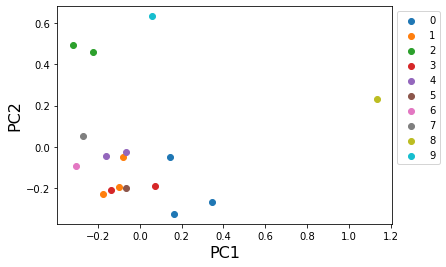

In [178]:
# ANSWER

ax = PCA_cluster_plot(data_log, k10_labels)

In [160]:
import sklearn

In [165]:
# normalize the data
# data_norm = pd.DataFrame(stats.zscore(data_log, axis = 1), 
                        #  columns = data_log.columns, index = data_log.index)

data_norm = sklearn.preprocessing.normalize(percs_df,norm='l2')
data_norm= pd.DataFrame(data_norm)
# compute the covariance
# cov_genes = data_norm.T.cov()

# # I specified diagonal vals == 1, but the cov function needs a slight fix
# n = data_norm.shape[1]
#cov_genes = cov_genes*(n-1)/n

# # visualize
# _ = sns.clustermap(cov_genes, cmap = 'coolwarm', center = 0)

In [169]:
data_norm = data_norm.T
data_norm.columns = [data_log.index]
data_norm

In [ ]:
np.log(1.000000e+05)

11.512925464970229

In [167]:
pca = decomposition.PCA().fit(data_norm.T)

# get the two important matrices & label them in pandas
pc_genes = pd.DataFrame(pca.components_,
                        columns = percs_df.index)
pc_samples = pd.DataFrame(pca.transform(data_norm.T),
                          index = percs_df.columns)

# get the explained variance, which will be useful later
exp_var = pca.explained_variance_ratio_

Components to capture 70% of variance:  4


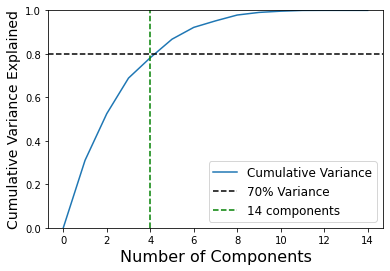

In [185]:
# get the cumulative variance
cum_var = exp_var.cumsum()

# find the number of components
index_80 = sum(cum_var <= 0.7)

# indices are zero-indexed, so the total number is one more than this
print('Components to capture 70% of variance: ', index_80+1)

# add a zero at the start so the plot extends all the way down
cum_var_plot = [0] + list(cum_var)

# plot
fig, ax = plt.subplots()
ax.plot(range(len(cum_var_plot)), cum_var_plot, label = 'Cumulative Variance')

# add some lines to illustrate the question
ax.axhline(0.8, color = 'k', linestyle = '--', label = '70% Variance')
ax.axvline(index_80+1, color = 'g', linestyle = '--', label = '14 components')

# limit the y axes
ax.set_ylim([0, 1])

# axes labels and legend
ax.set_xlabel('Number of Components', fontsize = 16)
ax.set_ylabel('Cumulative Variance Explained', fontsize = 14)
_ = ax.legend(fontsize = 12)

KeyError: "['b3361', 'b3519', 'b0948', 'b3411'] not found in axis"

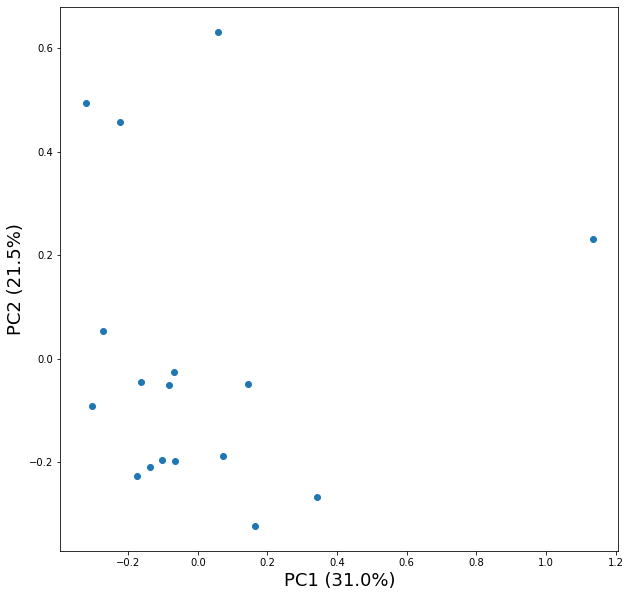

In [180]:
# ANSWER
pc1 = pc_genes.loc[0].to_frame('weight')
pc2 = pc_genes.loc[1].to_frame('weight')

# need the absolute values to sort by
pc1['abs_weight'] = pc1.weight.abs()
pc2['abs_weight'] = pc2.weight.abs()

# sort and keep only the top 5
pc1 = pc1.sort_values('abs_weight', ascending = False).iloc[0:5]
pc2 = pc2.sort_values('abs_weight', ascending = False).iloc[0:5]

# concatenate the gene table info
# pc1 = pd.concat([pc1, gene_table.loc[pc1.index]], axis = 1)
# pc2 = pd.concat([pc2, gene_table.loc[pc2.index]], axis = 1)
fig, ax = plt.subplots(figsize = (10, 10))

# scatter the sample loadings
ax.scatter(pc_samples[0], pc_samples[1])

# add the labels, use the exp_var
ax.set_xlabel('PC1 (%.1f%%)'%(exp_var[0]*100), fontsize = 18)
ax.set_ylabel('PC2 (%.1f%%)'%(exp_var[1]*100), fontsize = 18)

# add the arrows
# begin by getting the genes from 1.3.1
arrows_to_make = pc1.index.append(pc2.index)

# this would get crowded, so remove specific genes that overlap
arrows_to_make = arrows_to_make.drop(['b3361','b3519', 'b0948', 'b3411'])

# arrow length variable extends arrows to help in interpreting the plot
# text_scale determines how far text labels are from arrow tips (1 = on top of them)
arrow_length = 500
text_scale = 1.3

# the place the arrows start is up to you, so you can move it out of the way
start1 = 25
start2 = 40

# loop through each gene and add its arrow
for g in arrows_to_make:
    # directions in PC1 and 2
    g_weight_pc1 = pc_genes.loc[0, g]
    g_weight_pc2 = pc_genes.loc[1, g]
    
    # lengthen arrow by a constant factor
    g_weight_pc1 = g_weight_pc1 * arrow_length
    g_weight_pc2 = g_weight_pc2 * arrow_length
    
    # add the arrow
    ax.arrow(start1, start2, g_weight_pc1, g_weight_pc2, head_width = 2)
    
    # add the gene's name to the plot
    g_name = gene_table.gene_name[g]
    ax.text(start1 + (text_scale * g_weight_pc1),
            start2 + (text_scale * g_weight_pc2), 
            g_name)

In [ ]:
liver.reactions.EX_glc__D_c.Keq = 1
liver.reactions.EX_h_c.Keq = 1 
liver.reactions.EX_h2o_c.Keq = 1 
liver.reactions.EX_pi_c.Keq = 1 
liver.reactions.EX_pyr_c.Keq = 1 
liver.reactions.EX_lac__L_c.Keq = 1 
# liver.reactions.EX_nadh_c.Keq = 1 
# liver.reactions.EX_nad_c.Keq = 1 

In [ ]:
liver.boundary_conditions['glc__D_b']=0.010482807 ##M ## initial condition of the metabolite in the model
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=0.0064 ##M
liver.boundary_conditions['pi_b']=0.010482807 ##M
liver.boundary_conditions['pyr_b']=0.00048 ##M
liver.boundary_conditions['nadh_b']=4.63542E-06
liver.boundary_conditions['nad_b']=0.00182531
liver.boundary_conditions['lac__L_b']=0.003261838

In [ ]:
Boundary= [
             "EX_glc__D_c", 
            "EX_h_c", 
            "EX_h2o_c",
            'EX_pyr_c',
            'EX_pi_c',
    "ATPM",
    
#     'EX_nad_c',
    "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [ ]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
#                         or r== liver.reactions.GLCter or r== glycogenolysis.reactions.PIter
#                                or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
#                                 r== glycogenolysis.reactions.PYRt2m or 
#                                 r== glycogenolysis.reactions.L_LACt2r or 
#                                 r== glycogenolysis.reactions.PYRt2 or 
#                                 r== glycogenolysis.reactions.PEPtm or r== glycogenolysis.reactions.GLCt1 
#                                 or r== glycogenolysis.reactions.Ht
                       )
},
                      update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [ ]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [ ]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

In [ ]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
json_save = os.path.join(model_dir,liver.id + ".json")
json.save_json_model(model=liver, filename=json_save)